# Analysis of deep mutational scanning of the hemagglutinin of WSN influenza virus by Doud and Bloom (2016)

## Overview
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) performed deep mutational scanning on the hemagglutinin (HA) from A/WSN/1933 (H1N1) influenza virus.
In that original paper, the data was analyzed using the older [dms_tools](https://github.com/jbloomlab/dms_tools) software package.
Here we re-analyze the data using the newer [dms_tools2](https://github.com/jbloomlab/dms_tools2) software.

## Experimental summary
The goal of the experiment was to quantify the effect of all amino-acid mutations to HA on viral replication in cell culture.
To do this, [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) created three independent plasmid mutant libraries carrying nearly all codon mutations of HA. 
These plasmid mutant libraries are referred to as *mutDNA-1*, *mutDNA-2*, and *mutDNA-3*.
They then used these libraries to generate three libraries of mutant viruses, which they passaged at low MOI to create a genotype-phenotype link.
These three virus mutant libraries are referred to as *mutvirus-1*, *mutvirus-2*, and *mutvirus-3*.
In addition, they performed a single replicate of the some procedure using **wildtype** (unmutated plasmid) to create non-mutagenized virus -- these plasmid and virus samples are referred to as *wtDNA* and *wtvirus*.

All of these plasmid and virus samples were deep sequenced using barcoded-subamplicon sequencing to obtain high accuracy.
This notebook analyzes those data to determine the "preference" of each site in HA for each possible amino acid.

## Import modules and define general variables
Import Python modules, print version of [dms_tools2](https://github.com/jbloomlab/dms_tools2), define some general variables used throughout the notebook.

Some key variables defined below impact how the entire notebook runs:

* `ncpus` is the number of CPUs to use. It should not exceed the number that you specify if you are submitting your job via a queue-ing system such as `slurm` / `sbatch`.

* `use_existing` specifies whether we use existing results if they exist, or generate everything new. Note that `dms_tools2` programs just check for existing output but do not do true dependency tracking (as would be done by `make`, for instance) -- so if you have changed the inputs, then set this option from `yes` to `no` to re-run everything fresh.

In [1]:
import os
from collections import OrderedDict
import pandas
from IPython.display import display, HTML
import dms_tools2
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.0.dev0


## Define the samples
We first define basic information about the samples that is used for processing the barcoded subamplicon deep sequencing data.
Specifically, for each sample we create a [pandas](http://pandas.pydata.org/) DataFrame that gives the:
1. The sample name.
2. The SRA ([Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra)) accession for the deep sequencing data for that sample.

In [2]:
samples = pandas.DataFrame.from_records(
        [('mutDNA-1', 'SRR3113656'),
         ('mutDNA-2', 'SRR3113657'),
         ('mutDNA-3', 'SRR3113658'),
         ('mutvirus-1', 'SRR3113660'),
         ('mutvirus-2', 'SRR3113661'),
         ('mutvirus-3', 'SRR3113662'),
         ('wtDNA', 'SRR3113655'),
         ('wtvirus', 'SRR3113659')],
        columns=['name', 'SRA accession']
        )
display(HTML(samples.to_html(index=False)))

name,SRA accession
mutDNA-1,SRR3113656
mutDNA-2,SRR3113657
mutDNA-3,SRR3113658
mutvirus-1,SRR3113660
mutvirus-2,SRR3113661
mutvirus-3,SRR3113662
wtDNA,SRR3113655
wtvirus,SRR3113659


## Download the FASTQ files from the SRA
Before doing any analysis, we need to obtain the FASTQ files with the deep sequencing data.
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) uploaded these FASTQ files from their local server to the [Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra), so we simply download those files.

We download the FASQ files using the [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program from the [SRA Toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc).
If you do not already have this toolkit installed, you will need to install it by [following these instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std).
For the downloads to work, you need a relatively recent version of `fastq-dump`, so if this cell fails check your version of that program.

The code cell below does the following:
1. Creates a directory for storing the FASTQ files.
2. Downloads each sample using `fastq-dump`. To understand the commands used by `fastq-dump` below, [look here](https://edwards.sdsu.edu/research/fastq-dump/) since the [NCBI's instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) are sparse.
2. Renames each set of FASTQ files to have nice names like `mutDNA-1_R1.fastq.gz` / `mutDNA-1_R2.fastq.gz`.

Note that files are only downloaded if they do not already exist.

In [3]:
print("Downloading FASTQ files from the SRA using:")
!fastq-dump --version

# directory for FASTQ files
fastqdir = './FASTQ_files/' 
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)

# define the R1 FASTQ file name (file will be in fastqdir)
samples['R1'] = samples['name'] + '_R1.fastq.gz'

# download any FASTQ files that are not already present
for (i, row) in samples.iterrows():
    # r1filedownload / r2filedownload are initial file names given by fastq-dump 
    r1filedownload = os.path.join(fastqdir, '{0}_pass_1.fastq.gz'.format(row['SRA accession']))
    r2filedownload = r1filedownload.replace('_1.fastq.gz', '_2.fastq.gz')
    r1file = os.path.join(fastqdir, row['R1'])
    r2file = r1file.replace('_R1', '_R2')
    if os.path.isfile(r1file) and os.path.isfile(r2file):
        print("FASTQ files for {0} already exist".format(row['name']))
    else:
        print("Downloading FASTQ files for {0}...".format(row['name']))
        !fastq-dump --outdir {fastqdir} --gzip --readids --skip-technical \
                --dumpbase --clip --split-files --read-filter pass {row['SRA accession']}
        os.rename(r1filedownload, r1file)
        os.rename(r2filedownload, r2file)


fastq-dump : 2.8.2

FASTQ files for mutDNA-1 already exist
FASTQ files for mutDNA-2 already exist
FASTQ files for mutDNA-3 already exist
FASTQ files for mutvirus-1 already exist
FASTQ files for mutvirus-2 already exist
FASTQ files for mutvirus-3 already exist
FASTQ files for wtDNA already exist
FASTQ files for wtvirus already exist


## Align the deep sequencing data and count mutations
The alignments are made to the wildtype WSN HA coding sequence, which is available at [./data/WSN-HA.fasta](./data/WSN-HA.fasta).

In [4]:
# file containing wildtype WSN HA sequence
refseq = './data/WSN-HA.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)

# all samples will be in the same plotgroup
samples['plotgroup'] = ''
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we will write to a CSV file to use as input:")
display(HTML(samples.to_html(index=False)))
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}
print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we will write to a CSV file to use as input:


name,SRA accession,R1,plotgroup
mutDNA-1,SRR3113656,mutDNA-1_R1.fastq.gz,
mutDNA-2,SRR3113657,mutDNA-2_R1.fastq.gz,
mutDNA-3,SRR3113658,mutDNA-3_R1.fastq.gz,
mutvirus-1,SRR3113660,mutvirus-1_R1.fastq.gz,
mutvirus-2,SRR3113661,mutvirus-2_R1.fastq.gz,
mutvirus-3,SRR3113662,mutvirus-3_R1.fastq.gz,
wtDNA,SRR3113655,wtDNA_R1.fastq.gz,
wtvirus,SRR3113659,wtvirus_R1.fastq.gz,



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`.
All of these files are found in the directory specified by `--outdir`, and with the prefix specified by `summaryprefix`.
So we define them using this plot prefix plus the suffix for each plot.

The `*_readstats.pdf` plot below shows the statistics on the reads.
This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. 
None failed the Illumina filter as we had already filtered out those when we downloaded from the SRA using `fastq-dump`.

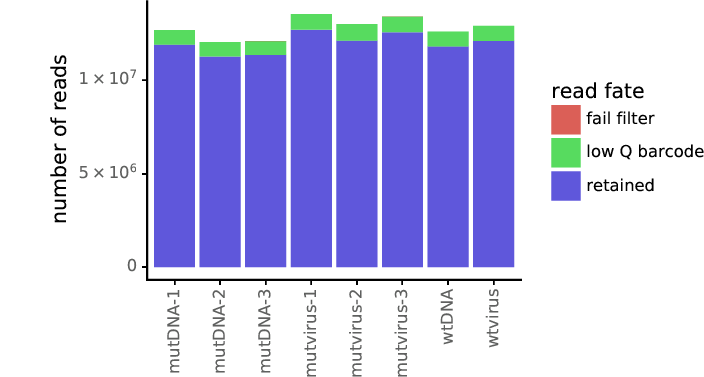

In [5]:
countsplotprefix = os.path.join(countsdir, 'summary')

showPDF(countsplotprefix + '_readstats.pdf', width=500)

The `*_readsperbc.pdf` shows how many times different barcodes were observed for each sample.
Recall that barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.
Many barcodes are observed multiple times, usually 2-5 times. 
There is also a large bar at 1, which probably corresponds to a mix of barcodes that were only observed once and sequencing errors on other barcodes that spuriously gave rise to an apparently unique sequence.

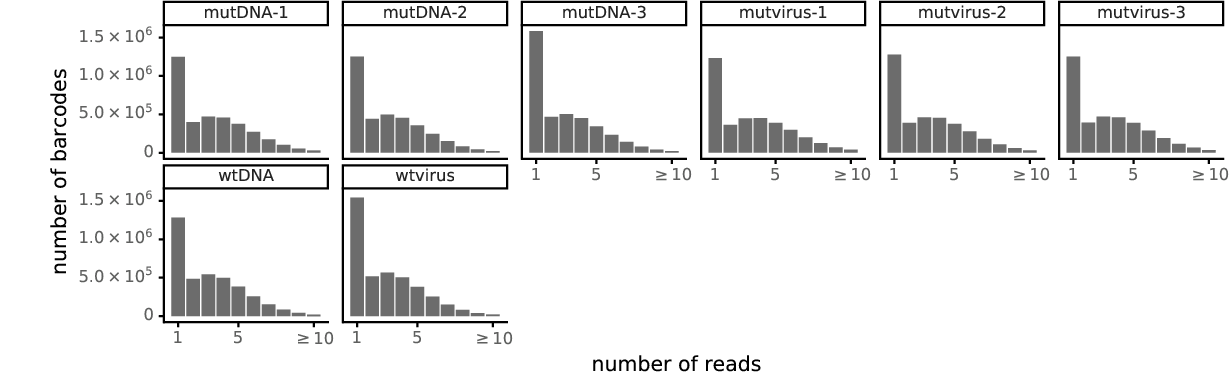

In [6]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows that statistics on the barcodes.
Some of the barcodes had to be discarded because they had too few reads, a small fraction with adequate reads were not alignable, and the rest aligned to the HA gene properly.

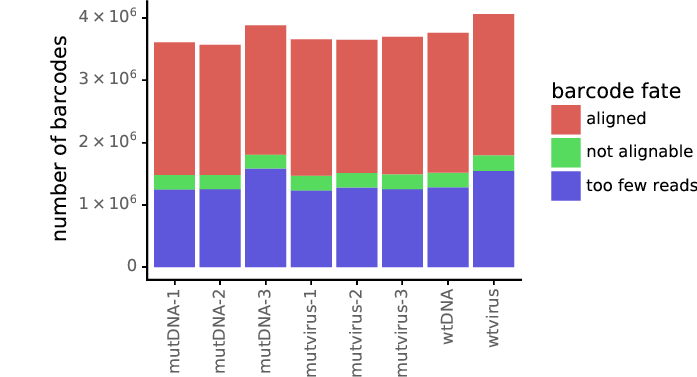

In [7]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene.
There is a bit of variation across the gene due to unequal numbers of barcodes for different subamplicons, but the variation is fairly modest.
The typicaly site has about $3 \times 10^5$ called codons, which makes sense as most samples had about $2 \times 10^6$ total aligned barcodes and the gene was split into 6 subamplicons.

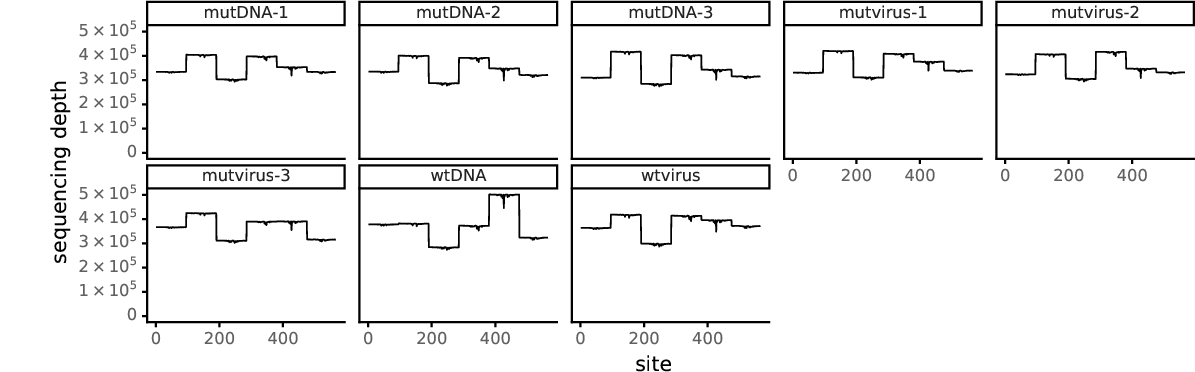

In [8]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site.
Generally, things are about as expected -- there is a fairly high mutation frequency across all sites in the mutant DNA library samples, mutations remain prevalent at many but not all sites in the mutant viruses, and the mutation frequency (presumably mostly sequencing errors) is much lower in the wildtype plasmid and wildtype virus.

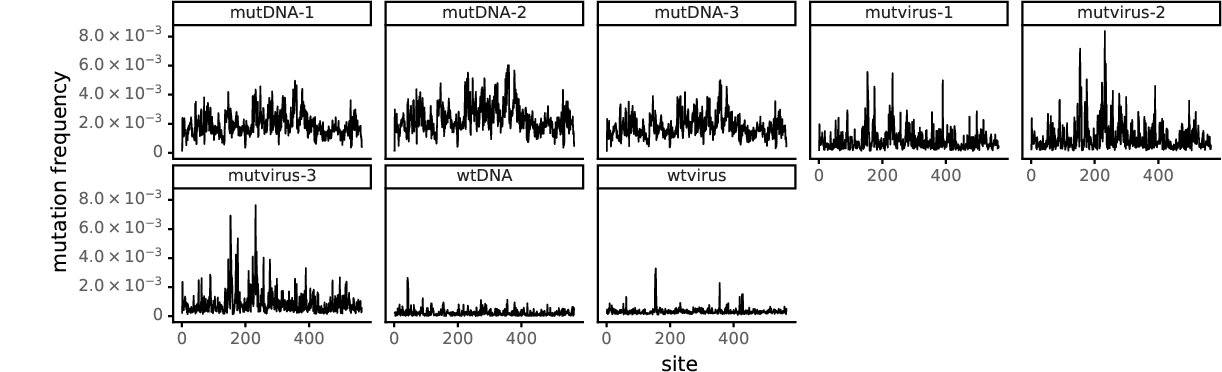

In [9]:
showPDF(countsplotprefix + '_mutfreq.pdf')